# StackOverflow dataset: CAVI vs noise
    
Experiments that explore the performance of CAVI at different levels of noise.

In [1]:
import collabclass
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Loading & preparing the data

In [2]:
with open("../_data/stackoverflow/categories-final.pkl", "rb") as f:
    cats = pickle.load(f)
    
cls2idx = {cls: idx for idx, cls in enumerate(sorted(set(cats.values())))}
k = len(cls2idx)

In [3]:
%%time
with open("../_data/stackoverflow/workspace.pkl", "rb") as f:
    data = pickle.load(f)

user_cnt = 0
item_cnt = 0
user2idx = dict()
item2idx = dict()

edges = list()

for uid, qid, _ in data["edges"]:
    if qid not in cats:
        # We dropped the question -> skip.
        continue
    if qid not in item2idx:
        item2idx[qid] = item_cnt
        item_cnt += 1
    if uid not in user2idx:
        user2idx[uid] = user_cnt
        user_cnt += 1
    edges.append((user2idx[uid], item2idx[qid]))

m = user_cnt
n = item_cnt
    
graph = collabclass.graph_from_edges(m, n, edges)

CPU times: user 17.3 s, sys: 1.04 s, total: 18.3 s
Wall time: 18.4 s


In [4]:
print("Number of users:  {:,}".format(m))
print("Number of items:  {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users:  644,443
Number of items:  704,982
Number of edges: 2,554,436


In [5]:
idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = cats[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

## Plot results

In [6]:
%%time
deltas = np.linspace(0.05, 0.85, num=9)
alpha = np.ones((m, k))

np.random.seed(0)
deltas2 = np.hstack(([0], deltas, [0.9]))
res2a = np.zeros(len(deltas2))
res2b = np.zeros(len(deltas2))
inf_deltas = np.array([1e-7, 0.18, 0.45, 0.65, 0.7, 0.73, 0.78, 0.78, 0.82, 0.82, 0.82])
for i, delta in enumerate(deltas2):
    print(".", end="", flush=True)
    vs_hat = collabclass.symmetric_channel(vs, k, delta=delta)
    beta = collabclass.init_beta(k, vs_hat, delta=inf_deltas[i])
    apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
    rankings = np.argsort(bpost, axis=1)[:,::-1]
    top1 = (rankings[:,0] != vs)
    ps = np.percentile(graph.item_idx[:,1], (50, 90, 98))
    mask = (graph.item_idx[:,1] >= ps[1])
    res2a[i] = np.count_nonzero(top1) / len(vs)
    res2b[i] = np.count_nonzero(top1[mask]) / np.count_nonzero(mask)
print()

...........
CPU times: user 1min 6s, sys: 949 ms, total: 1min 7s
Wall time: 1min 7s


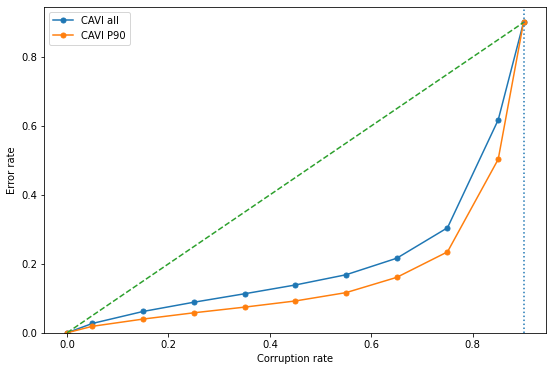

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(deltas2, res2a, marker="o", ms=5, label="CAVI all")
ax.plot(deltas2, res2b, marker="o", ms=5, label="CAVI P90")
ax.plot(deltas2, deltas2, ls="--")
ax.axvline(0.9, ls=":")
ax.set_ylim(bottom=0.0)
ax.set_xlabel("Corruption rate")
ax.set_ylabel("Error rate")
ax.legend()